# WhatPulse Keypress Stats Analyzer

By Kenneth Burchfiel

Released under the MIT license

*(I am not affiliated with WhatPulse (https://whatpulse.org) but highly recommend checking out the program, which I've used since September 2008. You can find my online WhatPulse page here: https://whatpulse.org/KBurchfiel)*

This script allows you to perform various analyses of your WhatPulse typing stats. It does so by accessing the local WhatPulse database on your computer; reading this data into Pandas DataFrames, and then summarizing and graphing that data. The output of the script includes:

1. Rolling average calculations at the 7-, 28-, and 365-day level
2. Percentile and rank calculations (so that you can see how today's keypresses compare to past days)
3. Weekly and hourly keypress stats
4. Static (.png) and interactive (.html) keypress charts

By converting this notebook into a Python file and then instructing your computer to run it on an hourly basis, you can also keep track of how much you're typing during your day. Which is sort of nerdy, to be honest. But so is this whole program ;) 

[More documentation will be provided in the future]

I'll first import a number of packages that the program will use:

In [1]:
import time
start_time = time.time() # Allows the program's runtime to be measured
import pandas as pd
import sqlalchemy
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
import statsmodels.api as sm
from scipy.stats import percentileofscore
import plotly.express as px
import kaleido
from IPython.display import Image
import datetime

## Importing Whatpulse data

In order to analyze my WhatPulse data, I'll first need to import it from my local Whatpulse SQLite database. I'll also import a copy of the Whatpulse SQLite database stored on my old laptop (so that my analysis doesn't have to be limited to my current computer's keypress data.)

You'll of course need to update the following cell with the path(s) to your own WhatPulse database(s).

Note: if you want to run this program on your own, but don't have access to a WhatPulse database, you can still run this program (assuming you've downloaded or cloned it from GitHub). Skip ahead to the line where I read in 

In [2]:
database_paths_list = [r'C:\Users\kburc\AppData\Local\whatpulse\whatpulse.db', r'C:\Users\kburc\D1V1\Documents\whatpulse_database_backups\a13r2_whatpulse.db'] 
# Note that the first path is to my computer's active database, and that the second path is to a copy of the database stored on my old computer. 

The following function analyzes each database's keypresses table at either the daily or hourly level.

In [3]:
def generate_keypress_totals(database_path, level = 'daily'):
    '''The level argument can be 'daily', in which case the DataFrame
    returned by the function will show daily keypress totals, or 'hourly',
    which will preserve the hourly keypress totals in the original database.'''
    file_name = database_path.split('\\')[-1]
    sqlalchemy_sqlite_engine = sqlalchemy.create_engine(
        'sqlite:///'+database_path) # Based on https://docs.sqlalchemy.org/en/13/dialects/sqlite.html#connect-strings
    sqlalchemy_connection = sqlalchemy_sqlite_engine.connect()
    df_keypresses = pd.read_sql("select * from keypresses", 
    con = sqlalchemy_sqlite_engine) # Simply reads all of the data from this 
    # table into a Pandas DataFrame
    df_keypresses = df_keypresses.query("day != '0000-00-00'").copy() # Removes
    # this blank date value from the database if it happens to be there
    if level == 'daily':
        df_keypresses = df_keypresses.pivot_table(
            index = 'day', values = 'count', aggfunc = 'sum')
        df_keypresses.sort_values('day', inplace = True)
    elif level == 'hourly': # The original data is already displayed 
        # at the hourly level, so there's no need for a pivot_table() call.
        df_keypresses.sort_values(['day', 'hour'], inplace = True)
    else:
        raise ValueError("Unrecognized level argument passed to function.")
    df_keypresses.rename(columns={'count':'keypresses'},inplace=True)  
    # The above line groups the hourly rows in the DataFrame into daily rows.
    return df_keypresses

In [4]:
keypress_databases_list = []

for path in database_paths_list:
    keypress_databases_list.append(generate_keypress_totals(path, level = 'daily'))

df_combined_daily_keypresses = pd.concat([keypress_databases_list[i] for i in range(len(keypress_databases_list))])
df_combined_daily_keypresses.sort_index(inplace=True)

# At this point, my copy of df_combined_daily_keypresses has multiple
# entries for a few days in which I logged keys on both computers.
# Therefore, the following line groups these entries into a single row
# for each date.
df_combined_daily_keypresses = df_combined_daily_keypresses.reset_index().pivot_table(index = 'day', values = 'keypresses', aggfunc = 'sum')
df_combined_daily_keypresses.index = pd.to_datetime(df_combined_daily_keypresses.index)

df_combined_daily_keypresses.to_csv('data/df_combined_daily_keypresses.csv')
df_combined_daily_keypresses

,keypresses
day,
2020-09-21,19081
2020-09-22,32771
2020-09-23,32065
2020-09-24,34698
2020-09-25,47038
...,...
2022-12-05,90447
2022-12-06,45684
2022-12-07,44317


The following line updates df_combined_daily_keypresses with the copy of this DataFrame that just got exported to a .csv. The purpose of this cell is to allow you to run this script even if you don't have your own WhatPulse database.

In [5]:
df_combined_daily_keypresses = pd.read_csv('data/df_combined_daily_keypresses.csv', index_col='day')
# The following line allows the DataFrame's index to be compatible with certain
# date operations that the following code block will perform.
df_combined_daily_keypresses.index = pd.to_datetime(df_combined_daily_keypresses.index)
df_combined_daily_keypresses

,keypresses
day,
2020-09-21,19081
2020-09-22,32771
2020-09-23,32065
2020-09-24,34698
2020-09-25,47038
...,...
2022-12-05,90447
2022-12-06,45684
2022-12-07,44317


The following code block fills in the DataFrame with missing dates (e.g. dates in which I did not have any keypresses). I want to add in those missing dates so that I can calculate more accurate rolling averages.

In [6]:
first_date = df_combined_daily_keypresses.index[0]
last_date = df_combined_daily_keypresses.index[-1]
full_date_range = pd.date_range(start=first_date, end = last_date) # https://pandas.pydata.org/docs/reference/api/pandas.date_range.html
df_combined_daily_keypresses = df_combined_daily_keypresses.reindex(full_date_range, fill_value=0) # See https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reindex.html
df_combined_daily_keypresses.index.name = 'Date'
df_combined_daily_keypresses.reset_index(inplace=True) 

Now that I have a more complete daily keypress history, I can begin performing analyses on this data. First, I will use the rolling() function within Pandas to calculate 7-, 28-, and 365-day moving averages.

In [7]:
df_combined_daily_keypresses['7_day_ma'] = df_combined_daily_keypresses['keypresses'].rolling(7).mean()
df_combined_daily_keypresses['28_day_ma'] = df_combined_daily_keypresses['keypresses'].rolling(28).mean() 
# I switched from a 30-day MA to a 28-day MA because my average keypresses vary significantly by weekday, meaning
# that a 30-day average would be skewed by the number of Saturdays and Sundays present in the data.
df_combined_daily_keypresses['365_day_ma'] = df_combined_daily_keypresses['keypresses'].rolling(365).mean()
df_combined_daily_keypresses['percentile'] = 100*df_combined_daily_keypresses['keypresses'].rank(pct=True)
df_combined_daily_keypresses['rank'] = df_combined_daily_keypresses['keypresses'].rank(ascending = False)
df_combined_daily_keypresses

,Date,keypresses,7_day_ma,28_day_ma,365_day_ma,percentile,rank
0,2020-09-21,19081,NaN,NaN,NaN,38.641975,498.0
1,2020-09-22,32771,NaN,NaN,NaN,65.308642,282.0
2,2020-09-23,32065,NaN,NaN,NaN,63.950617,293.0
3,2020-09-24,34698,NaN,NaN,NaN,67.839506,261.5
4,2020-09-25,47038,NaN,NaN,NaN,86.790123,108.0
...,...,...,...,...,...,...,...
805,2022-12-05,90447,34728.714286,26518.821429,20476.994521,100.000000,1.0
806,2022-12-06,45684,38310.285714,26836.428571,20442.558904,85.061728,122.0
807,2022-12-07,44317,38255.285714,26491.857143,20437.043836,83.209877,137.0
808,2022-12-08,44502,39751.857143,26594.571429,20513.197260,83.333333,136.0


<h2 style="color:cyan"> Here with editing</h2>

Adding in weekdays:

In [8]:
df_weekday_mapping = pd.DataFrame({"Number":[0, 1, 2, 3, 4, 5, 6], "Weekday":["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]})
# Weekday numbers in Python begin with 0 for Monday and end with 6 for Sunday. See https://docs.python.org/3/library/datetime.html#datetime.date.weekday
df_weekday_mapping

,Number,Weekday
0,0,Monday
1,1,Tuesday
2,2,Wednesday
3,3,Thursday
4,4,Friday
5,5,Saturday
6,6,Sunday


In [9]:
df_combined_daily_keypresses['weekday_num'] = df_combined_daily_keypresses['Date'].dt.weekday.copy()
df_combined_daily_keypresses

,Date,keypresses,7_day_ma,28_day_ma,365_day_ma,percentile,rank,weekday_num
0,2020-09-21,19081,NaN,NaN,NaN,38.641975,498.0,0
1,2020-09-22,32771,NaN,NaN,NaN,65.308642,282.0,1
2,2020-09-23,32065,NaN,NaN,NaN,63.950617,293.0,2
3,2020-09-24,34698,NaN,NaN,NaN,67.839506,261.5,3
4,2020-09-25,47038,NaN,NaN,NaN,86.790123,108.0,4
...,...,...,...,...,...,...,...,...
805,2022-12-05,90447,34728.714286,26518.821429,20476.994521,100.000000,1.0,0
806,2022-12-06,45684,38310.285714,26836.428571,20442.558904,85.061728,122.0,1
807,2022-12-07,44317,38255.285714,26491.857143,20437.043836,83.209877,137.0,2
808,2022-12-08,44502,39751.857143,26594.571429,20513.197260,83.333333,136.0,3


In [10]:
df_combined_daily_keypresses = df_combined_daily_keypresses.merge(df_weekday_mapping, left_on = 'weekday_num', right_on = 'Number', how = 'left')
# If the 'how' field is left blank, the resulting DataFrame will be sorted by weekday instead of by date.
# Sorting by the Date column is necessary here since the merge operation sorted the data by 
df_combined_daily_keypresses.drop(['weekday_num', 'Number'], axis = 1, inplace = True)
df_combined_daily_keypresses

,Date,keypresses,7_day_ma,28_day_ma,365_day_ma,percentile,rank,Weekday
0,2020-09-21,19081,NaN,NaN,NaN,38.641975,498.0,Monday
1,2020-09-22,32771,NaN,NaN,NaN,65.308642,282.0,Tuesday
2,2020-09-23,32065,NaN,NaN,NaN,63.950617,293.0,Wednesday
3,2020-09-24,34698,NaN,NaN,NaN,67.839506,261.5,Thursday
4,2020-09-25,47038,NaN,NaN,NaN,86.790123,108.0,Friday
...,...,...,...,...,...,...,...,...
805,2022-12-05,90447,34728.714286,26518.821429,20476.994521,100.000000,1.0,Monday
806,2022-12-06,45684,38310.285714,26836.428571,20442.558904,85.061728,122.0,Tuesday
807,2022-12-07,44317,38255.285714,26491.857143,20437.043836,83.209877,137.0,Wednesday
808,2022-12-08,44502,39751.857143,26594.571429,20513.197260,83.333333,136.0,Thursday


Summary daily keypress data statistics:

In [11]:
df_combined_daily_keypresses['keypresses'].describe()

count      810.000000
mean     25757.988889
std      18122.942332
min          0.000000
25%      10019.250000
50%      25121.000000
75%      38603.250000
max      90447.000000
Name: keypresses, dtype: float64

In [12]:
df_combined_daily_keypresses.tail(10) # Last 10 days of data

,Date,keypresses,7_day_ma,28_day_ma,365_day_ma,percentile,rank,Weekday
800,2022-11-30,44702,25320.285714,24778.892857,20283.361644,83.950617,131.0,Wednesday
801,2022-12-01,34026,30173.857143,24523.821429,20294.517808,66.543210,272.0,Thursday
802,2022-12-02,28416,33176.000000,24393.464286,20240.350685,57.901235,342.0,Friday
803,2022-12-03,2852,26565.285714,23985.178571,20208.687671,14.074074,697.0,Saturday
804,2022-12-04,22045,26798.428571,24571.785714,20260.328767,43.950617,455.0,Sunday
805,2022-12-05,90447,34728.714286,26518.821429,20476.994521,100.000000,1.0,Monday
806,2022-12-06,45684,38310.285714,26836.428571,20442.558904,85.061728,122.0,Tuesday
807,2022-12-07,44317,38255.285714,26491.857143,20437.043836,83.209877,137.0,Wednesday
808,2022-12-08,44502,39751.857143,26594.571429,20513.197260,83.333333,136.0,Thursday
809,2022-12-09,36200,40863.857143,27801.107143,20538.926027,70.987654,236.0,Friday


## My top 50 keypress totals:

In [13]:
df_max_keypresses = df_combined_daily_keypresses.sort_values('keypresses', ascending = False).reset_index(drop=True)
df_max_keypresses.insert(0, 'Rank', df_max_keypresses.index+1)
keypress_difference_list = [df_max_keypresses.iloc[i]['keypresses'] - df_max_keypresses.iloc[i+1]['keypresses'] for i in range(len(df_max_keypresses) -1 )]
# This list comprehension calculates the difference between each row and the row below it. This isn't possible for the final row,
# so we'll instead append a np.Nan to it.)
keypress_difference_list.append(np.NaN)
df_max_keypresses['difference_from_lower_rank'] = keypress_difference_list
df_max_keypresses.head(50)

,Rank,Date,keypresses,7_day_ma,28_day_ma,365_day_ma,percentile,rank,Weekday,difference_from_lower_rank
0,1,2022-12-05,90447,34728.714286,26518.821429,20476.994521,100.000000,1.0,Monday,12694.0
1,2,2021-02-22,77753,47983.000000,41390.857143,NaN,99.876543,2.0,Monday,1440.0
2,3,2020-11-23,76313,50377.571429,39924.107143,NaN,99.753086,3.0,Monday,869.0
3,4,2020-11-19,75444,47285.571429,37945.892857,NaN,99.629630,4.0,Thursday,1656.0
4,5,2021-11-09,73788,37843.285714,30462.071429,29584.802740,99.506173,5.0,Tuesday,878.0
5,6,2022-05-03,72910,30511.428571,28489.285714,24401.624658,99.382716,6.0,Tuesday,2319.0
6,7,2021-02-08,70591,30177.428571,34437.357143,NaN,99.259259,7.0,Monday,2278.0
7,8,2021-04-06,68313,40455.857143,40719.178571,NaN,99.135802,8.0,Tuesday,383.0
8,9,2021-02-15,67930,46174.571429,40268.535714,NaN,99.012346,9.0,Monday,397.0
9,10,2020-11-30,67533,20747.428571,36843.714286,NaN,98.888889,10.0,Monday,28.0


<BarContainer object of 50 artists>

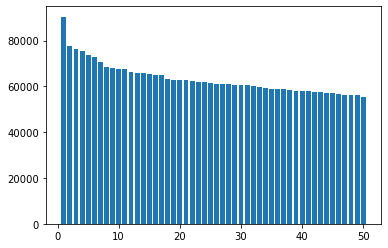

In [14]:
plt.bar(x = df_max_keypresses.head(50)['Rank'], height= df_max_keypresses.head(50)['keypresses'])

In [15]:
df_combined_daily_keypresses.describe()

,keypresses,7_day_ma,28_day_ma,365_day_ma,percentile,rank
count,810.000000,804.000000,783.000000,446.000000,810.000000,810.00000
mean,25757.988889,25666.749289,25445.367816,24895.410787,50.061728,405.50000
std,18122.942332,10463.352123,7726.260659,3090.879354,28.883167,233.95365
min,0.000000,0.000000,8775.535714,20131.378082,2.716049,1.00000
25%,10019.250000,18368.678571,20024.178571,22908.244521,25.092593,203.25000
50%,25121.000000,26252.214286,24910.892857,24019.564384,50.061728,405.50000
75%,38603.250000,33119.892857,31058.714286,27859.967123,75.030864,607.75000
max,90447.000000,50377.571429,41579.714286,30033.476712,100.000000,789.00000


## Keypress percentiles:

In [16]:
df_combined_daily_keypresses['keypresses'].describe(percentiles=np.linspace(0.9,1,11))

count      810.000000
mean     25757.988889
std      18122.942332
min          0.000000
50%      25121.000000
90%      50053.100000
91%      51141.440000
92%      53012.960000
93%      54582.400000
94%      55864.380000
95%      57678.200000
96%      59653.080000
97%      61373.010000
98%      64562.680000
99%      67894.270000
100%     90447.000000
max      90447.000000
Name: keypresses, dtype: float64

Finding the percentile corresponding to a day with only a single keypress:

In [17]:
percentileofscore(df_combined_daily_keypresses['keypresses'], 1)

5.432098765432099

## Full percentile list (at 5% increments):

In [18]:
df_percentiles = df_combined_daily_keypresses['keypresses'].describe(
percentiles=np.linspace(0,1,21))[4:-1].reset_index().sort_values(
    'keypresses', ascending = False).reset_index(drop=True).rename(columns={'index':'percentile'})
# The first 3 rows and final row provide descriptive statistics that aren't 
# necessary to include within this DataFrame, so we can get rid of them
# by adding [4:-1] to the end of this line.
# Calling reset_index() twice appears inefficient, but it makes it easier
# to sort by a particular value (in this case, keypresses).
keypress_difference_list = [df_percentiles.iloc[i, 1] - df_percentiles.iloc[i+1, 1] for i in range(len(df_percentiles) -1 )]
# This list comprehension calculates the difference between each row and the row below it. This isn't possible for the final row,
# so we'll instead append a np.Nan to it.)
keypress_difference_list.append(np.NaN)
df_percentiles['difference_from_lower_percentile'] = keypress_difference_list
df_percentiles

,percentile,keypresses,difference_from_lower_percentile
0,100%,90447.00,32768.80
1,95%,57678.20,7625.10
2,90%,50053.10,4464.30
3,85%,45588.80,3852.40
4,80%,41736.40,3133.15
5,75%,38603.25,2807.55
6,70%,35795.70,3257.65
7,65%,32538.05,2724.85
8,60%,29813.20,2809.65
9,55%,27003.55,1882.55


<BarContainer object of 21 artists>

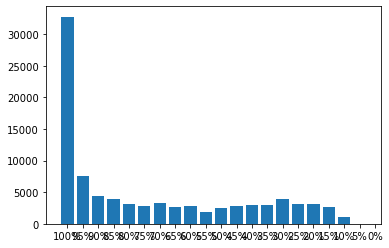

In [19]:
plt.bar(df_percentiles['percentile'], df_percentiles['difference_from_lower_percentile'])

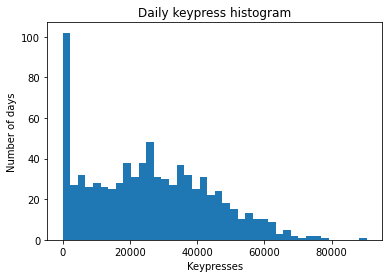

In [20]:
plt.hist(df_combined_daily_keypresses['keypresses'], bins = 40)
plt.xlabel('Keypresses')
plt.ylabel('Number of days')
plt.title('Daily keypress histogram')
plt.savefig('graphs\\keypress_histogram.png')

In [21]:
df_weekday_pivot = df_combined_daily_keypresses.pivot_table(index = 'Weekday', values = 'keypresses', aggfunc = 'mean').sort_values('keypresses', ascending = False).reset_index()
df_weekday_pivot

,Weekday,keypresses
0,Tuesday,33740.120690
1,Monday,33278.672414
2,Thursday,31680.560345
3,Wednesday,30539.301724
4,Friday,24412.155172
5,Saturday,14314.582609
6,Sunday,12124.347826


In [22]:
# The following line makes the Weekday column categorical so that it can be 
# sorted in a custom order (which I specify in the 'categories' parameter). 
# See https://pandas.pydata.org/docs/user_guide/categorical.html
df_weekday_pivot['Weekday'] = pd.Categorical(df_weekday_pivot['Weekday'], 
categories = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 
'Thursday', 'Friday', 'Saturday'], ordered = True)

In [23]:
df_weekday_pivot.sort_values('Weekday', inplace = True)
df_weekday_pivot

,Weekday,keypresses
6,Sunday,12124.347826
1,Monday,33278.672414
0,Tuesday,33740.120690
3,Wednesday,30539.301724
2,Thursday,31680.560345
4,Friday,24412.155172
5,Saturday,14314.582609


Graphing my average keypresses per weekday:

In [24]:
df_weekday_pivot

,Weekday,keypresses
6,Sunday,12124.347826
1,Monday,33278.672414
0,Tuesday,33740.120690
3,Wednesday,30539.301724
2,Thursday,31680.560345
4,Friday,24412.155172
5,Saturday,14314.582609


The following cell creates a series of colors that will be used as the bar labels for each weekday. Weekdays with more keypresses will be bluer, and weekdays with fewer keypresses will be grayer.

In [25]:
max_weekday_keypresses = max(df_weekday_pivot['keypresses'])
min_weekday_keypresses = min(df_weekday_pivot['keypresses'])
# The following line designates the colors as (r, g, b) tuples. r and g are always set to 0.5. b will be 0.5 on the day with the fewest keypresses and 1 on the day with the most keypresses.
bar_color_list = [(0.5, 0.5, 0.5 + 0.5*(keypress_value - min_weekday_keypresses)/(max_weekday_keypresses - min_weekday_keypresses)) for keypress_value in df_weekday_pivot['keypresses']]
bar_color_list

[(0.5, 0.5, 0.5),
 (0.5, 0.5, 0.989326121282487),
 (0.5, 0.5, 1.0),
 (0.5, 0.5, 0.9259610335073425),
 (0.5, 0.5, 0.9523597801053225),
 (0.5, 0.5, 0.7842324311946538),
 (0.5, 0.5, 0.5506628839142775)]

## Creating a chart of weekly average keypresses:

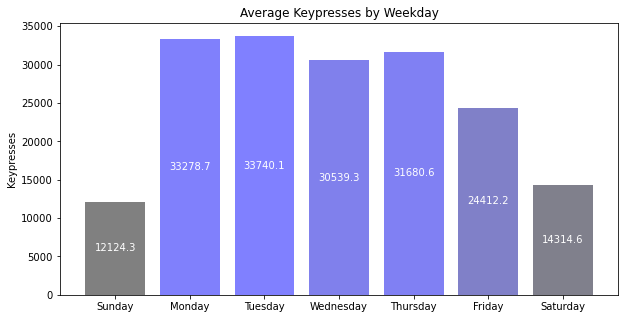

In [26]:
fig, ax = plt.subplots(figsize = [10, 5])
fig.set_facecolor('white')
bc = ax.bar(x = df_weekday_pivot['Weekday'], height = df_weekday_pivot['keypresses'], color = bar_color_list) # bc stands for 'bar container'
ax.bar_label(bc, label_type = 'center', color = 'white') 
plt.title("Average Keypresses by Weekday")
plt.ylabel("Keypresses")
# See https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html
plt.savefig('graphs\\average_keypresses_by_weekday.png', dpi=400)

In [27]:
print("Total keypresess since", str(df_combined_daily_keypresses.iloc[0]['Date'])+":",'{:,}'.format(sum(df_combined_daily_keypresses['keypresses'])))

Total keypresess since 2020-09-21 00:00:00: 20,863,971


In [28]:
df_combined_daily_keypresses.tail(50) # Last 50 days

,Date,keypresses,7_day_ma,28_day_ma,365_day_ma,percentile,rank,Weekday
760,2022-10-21,34606,18232.285714,20410.785714,20431.328767,67.654321,263.0,Friday
761,2022-10-22,16922,20429.142857,20633.071429,20413.673973,35.061728,527.0,Saturday
762,2022-10-23,12601,22229.285714,20244.000000,20422.243836,28.271605,582.0,Sunday
763,2022-10-24,31296,24967.714286,20615.464286,20507.986301,62.222222,307.0,Monday
764,2022-10-25,36769,25771.142857,20734.607143,20458.153425,71.975309,228.0,Tuesday
765,2022-10-26,26905,25745.714286,20627.357143,20359.476712,54.629630,368.5,Wednesday
766,2022-10-27,43233,28904.571429,22165.571429,20348.608219,82.222222,145.0,Thursday
767,2022-10-28,28086,27973.142857,23168.642857,20288.953425,57.160494,348.0,Friday
768,2022-10-29,20939,28547.000000,23916.464286,20342.063014,41.975309,471.0,Saturday
769,2022-10-30,4952,27454.285714,23735.964286,20327.578082,16.543210,677.0,Sunday


# (See above for recent keypress stats)

In [29]:
days_with_data = len(df_combined_daily_keypresses)
#  The following column cell shows the ranks immediately above the ranks for the most recent day.
keypresses_today = df_combined_daily_keypresses.iloc[-1]['keypresses']
percentile_today = df_combined_daily_keypresses.iloc[-1]['percentile']
rank_today = df_combined_daily_keypresses.iloc[-1]['rank']
print("Ranks are out of", days_with_data, "days.")
print(f"Today's keypresses: {keypresses_today}")
print(f"Your keypress totals 7, 28, and 365 days ago were \
{df_combined_daily_keypresses.iloc[-8]['keypresses']}, \
{df_combined_daily_keypresses.iloc[-29]['keypresses']}, \
and {df_combined_daily_keypresses.iloc[-366]['keypresses']}, respectively.")
# If your keypresses today are higher than these values, the moving averages
# associated with those values will increase.
print(f"Today's percentile: {percentile_today}")
print(f"Today's rank: {rank_today} (in front of {days_with_data - rank_today} days)")

Ranks are out of 810 days.
Today's keypresses: 36200
Your keypress totals 7, 28, and 365 days ago were 28416, 2417, and 26809, respectively.
Today's percentile: 70.98765432098766
Today's rank: 236.0 (in front of 574.0 days)


Days ranked just ahead of today (along with today's rank):

In [30]:
df_days_with_higher_keypresses = df_combined_daily_keypresses.sort_values('rank').query("rank <= @rank_today").tail(11)
keypress_difference_list = [df_days_with_higher_keypresses.iloc[i]['keypresses'] - df_days_with_higher_keypresses.iloc[i+1]['keypresses'] for i in range(len(df_days_with_higher_keypresses) -1 )]
keypress_difference_list.append(np.NaN)
df_days_with_higher_keypresses['diff_from_following_day'] = keypress_difference_list
df_days_with_higher_keypresses['diff_from_current_day'] = df_days_with_higher_keypresses['keypresses'] - df_days_with_higher_keypresses.iloc[-1]['keypresses']
df_days_with_higher_keypresses

,Date,keypresses,7_day_ma,28_day_ma,365_day_ma,percentile,rank,Weekday,diff_from_following_day,diff_from_current_day
778,2022-11-08,36791,27217.714286,25112.857143,20486.873973,72.222222,226.0,Tuesday,6.0,591
215,2021-04-24,36785,34246.857143,35544.892857,NaN,72.098765,227.0,Saturday,16.0,585
764,2022-10-25,36769,25771.142857,20734.607143,20458.153425,71.975309,228.0,Tuesday,5.0,569
575,2022-04-19,36764,24476.857143,29817.750000,23880.008219,71.851852,229.0,Tuesday,4.0,564
84,2020-12-14,36760,38186.857143,35803.714286,NaN,71.728395,230.0,Monday,104.0,560
326,2021-08-13,36656,26896.428571,30804.857143,NaN,71.604938,231.0,Friday,196.0,456
451,2021-12-16,36460,25772.000000,24418.571429,28453.857534,71.481481,232.0,Thursday,146.0,260
333,2021-08-20,36314,23399.857143,28847.857143,NaN,71.358025,233.0,Friday,47.0,114
417,2021-11-12,36267,37110.571429,28507.392857,29510.983562,71.234568,234.0,Friday,24.0,67
179,2021-03-19,36243,37070.571429,32789.250000,NaN,71.111111,235.0,Friday,43.0,43


Looking for days with identical keypress totals:

In [31]:
duplicated_keypress_dates = df_combined_daily_keypresses[df_combined_daily_keypresses.duplicated(subset = 'keypresses', keep = False)].query('keypresses > 0').sort_values('keypresses', ascending = False)
# print(f"There have been {len(duplicated_keypress_dates)} dates that share keypresses with at least one other date. (This total does not include dates with 0 keypresses.)")
len(duplicated_keypress_dates)

14

In [32]:
duplicated_keypress_dates

,Date,keypresses,7_day_ma,28_day_ma,365_day_ma,percentile,rank,Weekday
32,2020-10-23,48908,41125.571429,37996.178571,NaN,88.950617,90.5,Friday
183,2021-03-23,48908,36708.000000,32516.464286,NaN,88.950617,90.5,Tuesday
3,2020-09-24,34698,NaN,NaN,NaN,67.839506,261.5,Thursday
124,2021-01-23,34698,34726.428571,24214.178571,NaN,67.839506,261.5,Saturday
318,2021-08-05,32184,29066.857143,29787.500000,NaN,64.506173,288.5,Thursday
676,2022-07-29,32184,26384.571429,26299.000000,23180.561644,64.506173,288.5,Friday
687,2022-08-09,26905,21784.571429,25372.785714,22972.580822,54.629630,368.5,Tuesday
765,2022-10-26,26905,25745.714286,20627.357143,20359.476712,54.629630,368.5,Wednesday
55,2020-11-15,26550,36325.285714,35269.428571,NaN,53.641975,376.5,Sunday
645,2022-06-28,26550,12407.857143,12670.821429,23373.895890,53.641975,376.5,Tuesday


In [33]:
# Total keypresses during MBA:

sum(df_combined_daily_keypresses.query(
    "Date >= '2020-08-20' & Date <= '2022-05-04'")['keypresses'])

16377578

In [34]:
df_combined_daily_keypresses

,Date,keypresses,7_day_ma,28_day_ma,365_day_ma,percentile,rank,Weekday
0,2020-09-21,19081,NaN,NaN,NaN,38.641975,498.0,Monday
1,2020-09-22,32771,NaN,NaN,NaN,65.308642,282.0,Tuesday
2,2020-09-23,32065,NaN,NaN,NaN,63.950617,293.0,Wednesday
3,2020-09-24,34698,NaN,NaN,NaN,67.839506,261.5,Thursday
4,2020-09-25,47038,NaN,NaN,NaN,86.790123,108.0,Friday
...,...,...,...,...,...,...,...,...
805,2022-12-05,90447,34728.714286,26518.821429,20476.994521,100.000000,1.0,Monday
806,2022-12-06,45684,38310.285714,26836.428571,20442.558904,85.061728,122.0,Tuesday
807,2022-12-07,44317,38255.285714,26491.857143,20437.043836,83.209877,137.0,Wednesday
808,2022-12-08,44502,39751.857143,26594.571429,20513.197260,83.333333,136.0,Thursday


In [35]:
df_combined_daily_keypresses['Date']

0     2020-09-21
1     2020-09-22
2     2020-09-23
3     2020-09-24
4     2020-09-25
         ...    
805   2022-12-05
806   2022-12-06
807   2022-12-07
808   2022-12-08
809   2022-12-09
Name: Date, Length: 810, dtype: datetime64[ns]

## Two different methods of visualizing this keypress data

Now that we have a DataFrame showing daily keypresses and multiple moving averages, it's time to visualize it! I'll show two methods for doing so here. First, I'll create a static graph using Matplotlib. Next, I'll use Plotly to create an interactive .html graph (along with a static .png copy of that graph.)

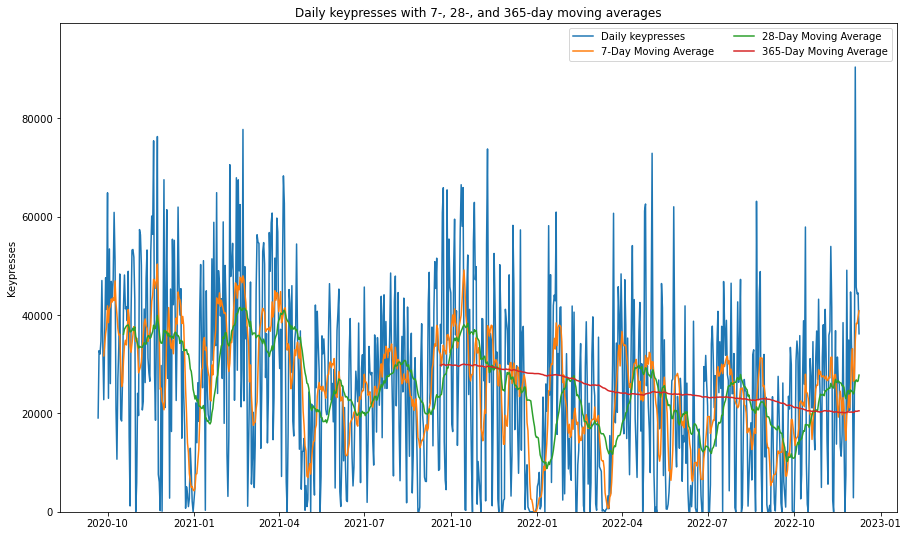

In [36]:
fig, ax = plt.subplots(figsize=[15,9])
fig.set_facecolor('white')
ax.set_ylim(0, max(df_combined_daily_keypresses['keypresses'])*1.1) # This 
# gives the y axis a bit more space to fit in the legend. Using a multiple is
# more flexible than is adding a specific number of keystrokes to the axis.)

ax.plot(df_combined_daily_keypresses['Date'], df_combined_daily_keypresses['keypresses'],label='Daily keypresses')
ax.plot(df_combined_daily_keypresses['Date'], df_combined_daily_keypresses['7_day_ma'],label='7-Day Moving Average')
ax.plot(df_combined_daily_keypresses['Date'], df_combined_daily_keypresses['28_day_ma'],label='28-Day Moving Average')
ax.plot(df_combined_daily_keypresses['Date'], df_combined_daily_keypresses['365_day_ma'],label='365-Day Moving Average')
plt.ylabel('Keypresses')
plt.legend(ncol = 2)
plt.title('Daily keypresses with 7-, 28-, and 365-day moving averages')
plt.savefig('graphs\\daily_keypresses_and_MAs.png', dpi=400)

A similar chart can be made using Plotly. The advantage of this chart is that, being HTML-based, it is interactive in nature. Thus, you can hover over the lines to view the values corresponding to those lines and zoom in to get a closer look at a particular section of the graph.

In [37]:
px_keypresses_line_chart = px.line(df_combined_daily_keypresses, x = 'Date', y = ['keypresses', '7_day_ma', '28_day_ma', '365_day_ma']) # Note that multiple y values can be passed to the line chart. 

px_keypresses_line_chart.write_html('graphs\\px_daily_keypresses_and_mas.html')

px_keypresses_line_chart 

Note that the above output will likely not show if you are viewing this notebook on GitHub. You'll instead need to download it to view the HTML output. (You can open it on your computer using a web browser.)

Plotly graphs can also be saved as static images:

In [38]:
image_width = 2600 # Larger widths will produce more detailed graphs but 
# smaller legends, so you may need to tweak this setting until you find a value
# that works for your own graph.
image_height = image_width * 9/16 # Preserves an HD/UHD aspect ratio

px_keypresses_line_chart.write_image('graphs\\px_daily_keypresses_and_mas_static.png', width = image_width, height = image_height, engine = 'kaleido')
# See https://plotly.com/python/static-image-export/

Here's a copy of this image:

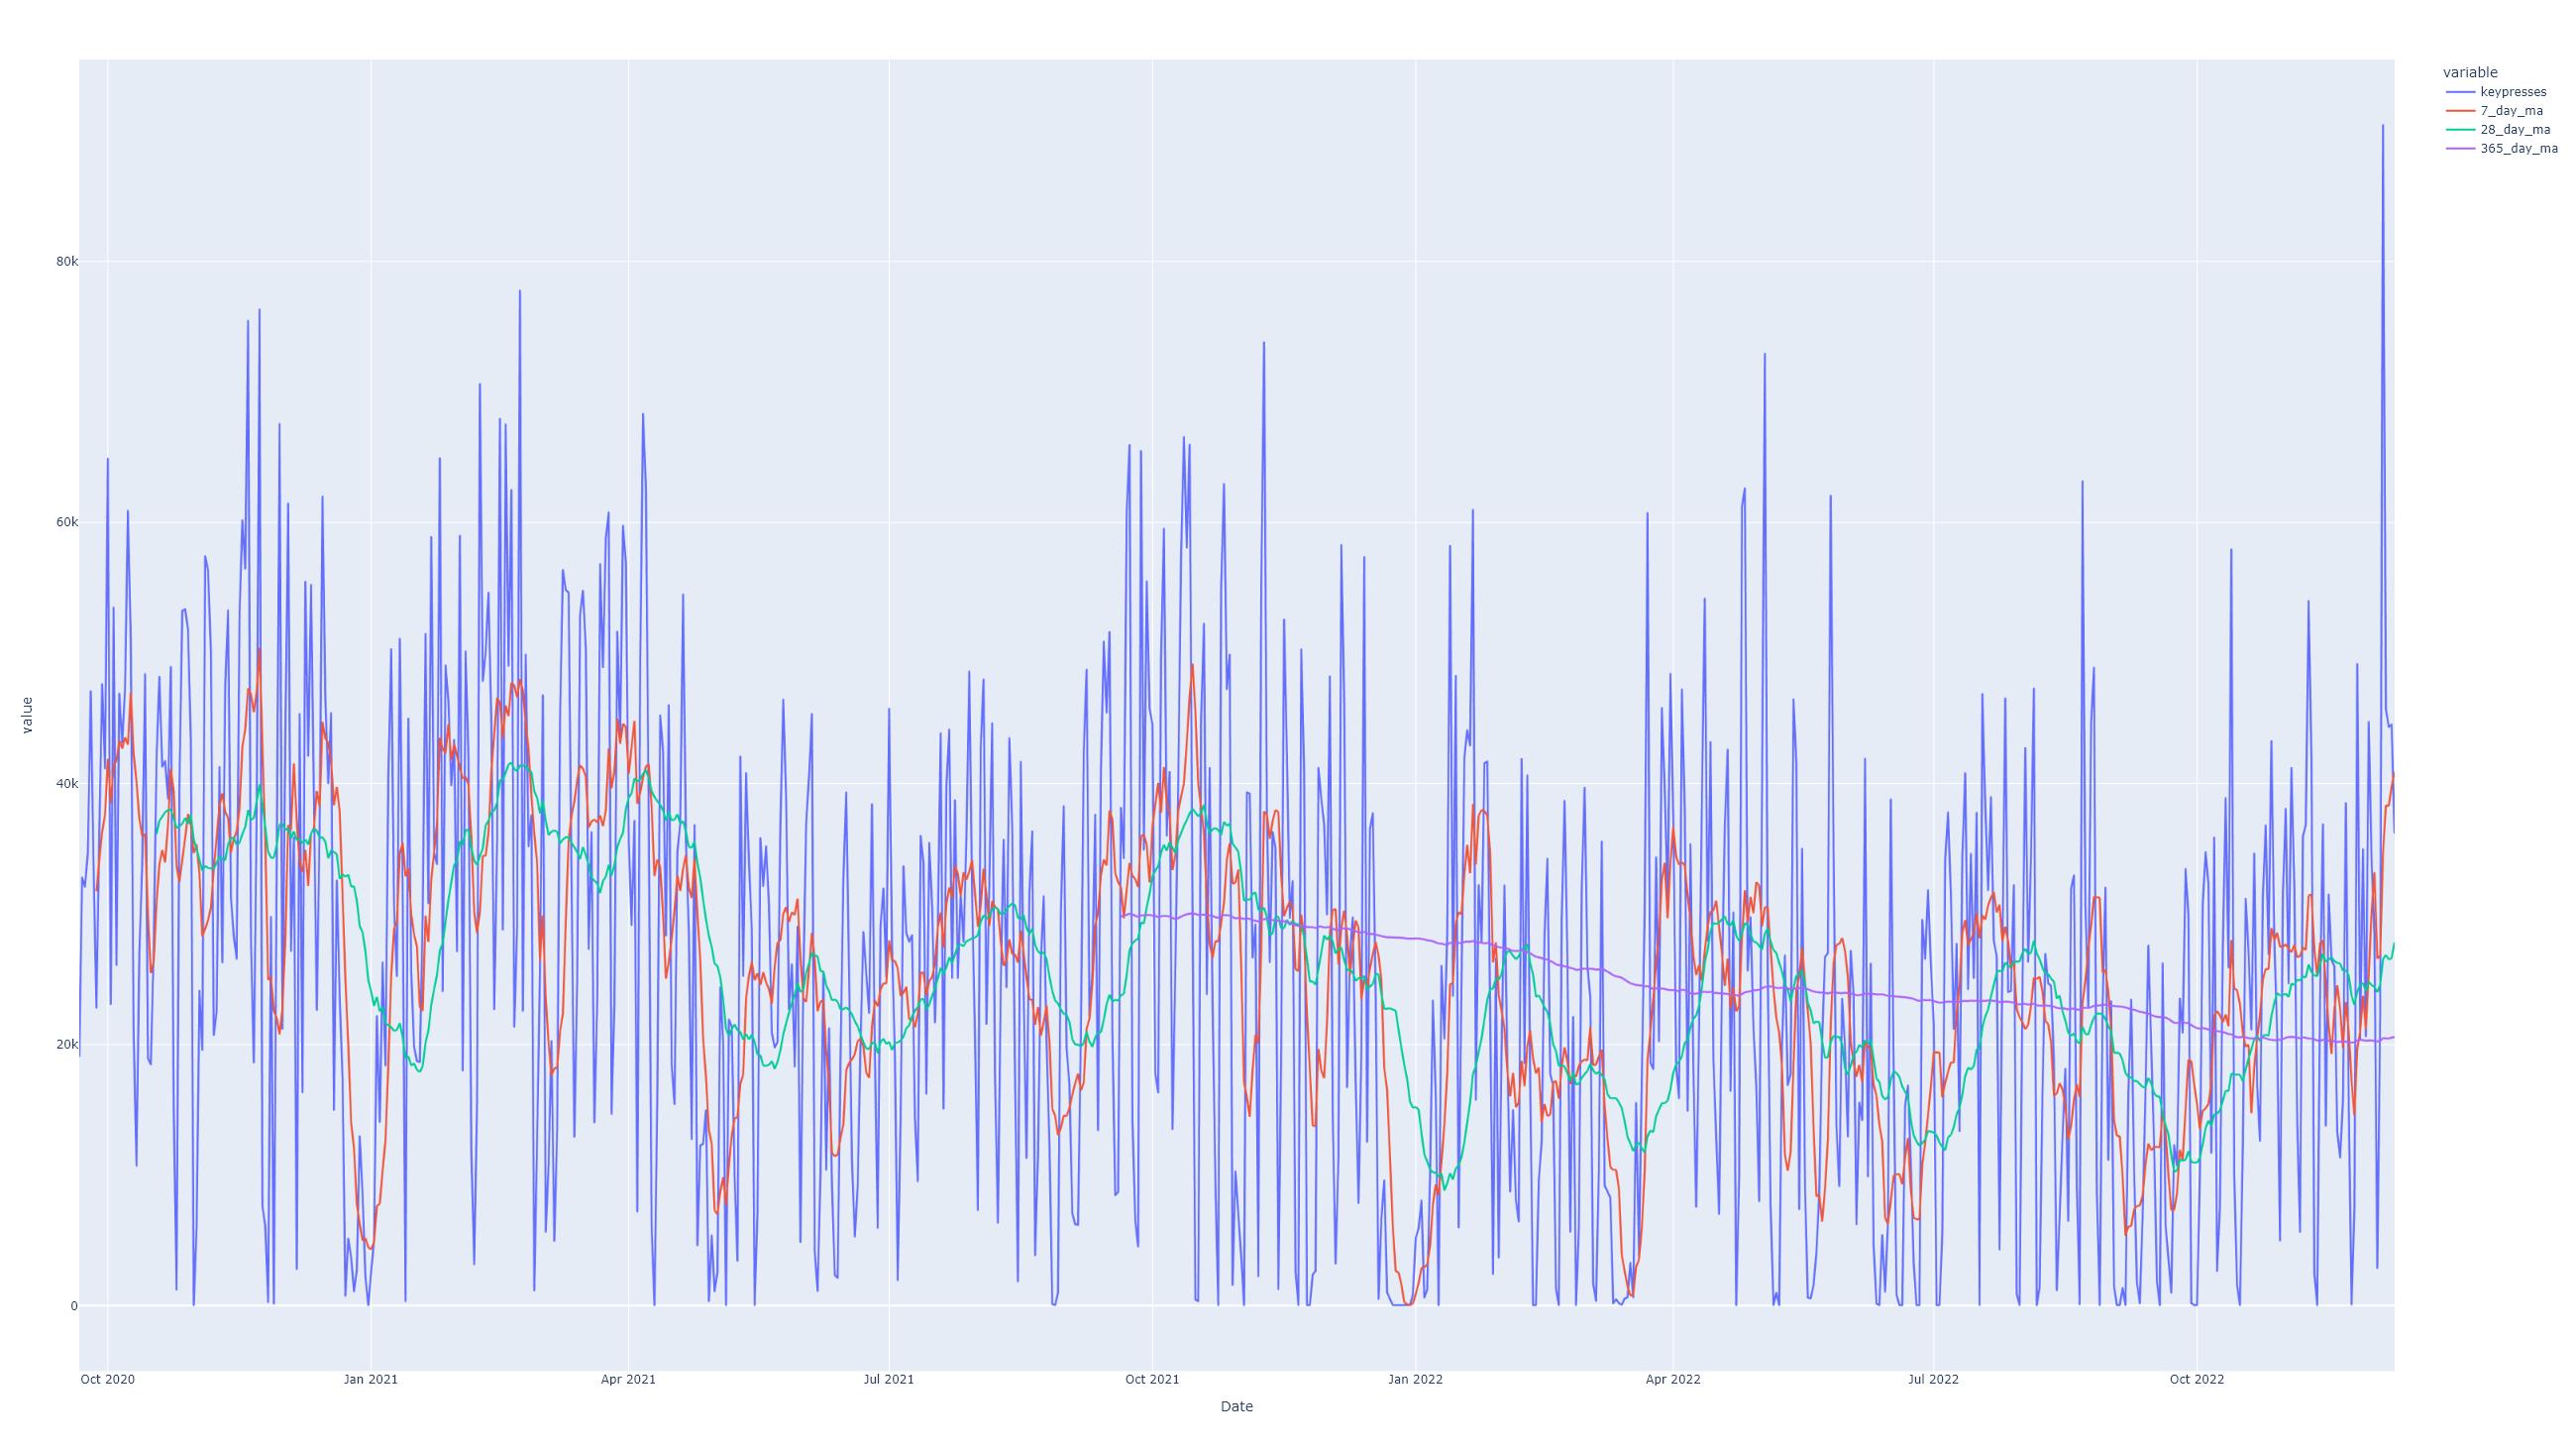

In [39]:
Image('graphs\\px_daily_keypresses_and_mas_static.png')

In [40]:
test_df = df_combined_daily_keypresses.copy()

## Monthly keypress totals:

In [41]:
df_monthly_keypresses = test_df.set_index('Date').resample('M').sum()['keypresses'].reset_index()
df_monthly_keypresses['Month'] = df_monthly_keypresses['Date'].dt.to_period('M')
df_monthly_keypresses['Year'] = df_monthly_keypresses['Date'].dt.to_period('Y')
df_monthly_keypresses.drop('Date', axis = 1, inplace = True)
df_monthly_keypresses['keypresses'] = df_monthly_keypresses.pop('keypresses')
df_monthly_keypresses

,Month,Year,keypresses
0,2020-09,2020,346918
1,2020-10,2020,1140421
2,2020-11,2020,1061614
3,2020-12,2020,823763
4,2021-01,2021,980116
5,2021-02,2021,1088404
6,2021-03,2021,1142850
7,2021-04,2021,833464
8,2021-05,2021,700155
9,2021-06,2021,621894


The following code shows my monthly keypresses from October to April during my 2-year MBA program.

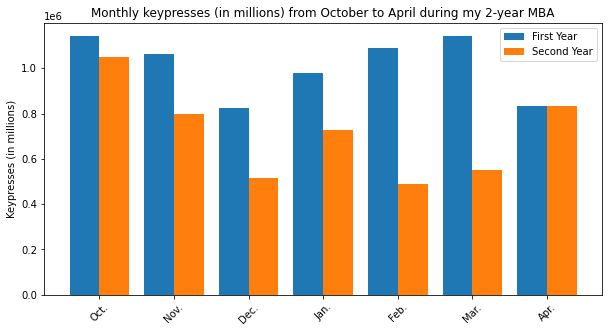

In [42]:
fig, axes = plt.subplots(figsize=[10, 5])
fig.set_facecolor('white')
# Much of the following code was based on:
# https://matplotlib.org/3.5.0/gallery/lines_bars_and_markers/barchart.html
df_first_year = df_monthly_keypresses.query("Month >= '2020-10' & Month <= '2021-04'").copy()
df_second_year = df_monthly_keypresses.query("Month >= '2021-10' & Month <= '2022-04'").copy()
width = 0.4
x = np.arange(len(df_first_year))
axes.bar(x = x - width/2, height = df_first_year['keypresses'], label = 'First Year', width = width)
axes.bar(x = x + width/2, height = df_second_year['keypresses'], label = 'Second Year', width = width)
axes.set_xticks(x, ['Oct.', 'Nov.', 'Dec.', 'Jan.', 'Feb.', 'Mar.', 'Apr.'], rotation = 45)
plt.legend()
plt.ylabel('Keypresses (in millions)')
plt.title('Monthly keypresses (in millions) from October to April during my 2-year MBA')
plt.savefig('graphs\\monthly_keypresses_during_MBA.png', dpi=400)

List of tables in each WhatPulse database file:

In [43]:
# output = sqlalchemy_connection.execute("SELECT name FROM sqlite_schema WHERE type='table' ORDER BY name;") # From https://www.sqlite.org/faq.html#q7 
# print(output.all())
# Tables: [('application_active_hour',), ('application_bandwidth',), ('application_ignore',), ('application_uptime',), ('applications',), ('applications_upgrades',), ('computer_info',), ('country_bandwidth',), ('fact',), ('geekwindow_labels',), ('input_per_application',), ('keycombo_frequency',), ('keycombo_frequency_application',), ('keypress_frequency',), ('keypress_frequency_application',), ('keypresses',), ('last_update_time',), ('milestones',), ('milestones_log',), ('mouseclicks',), ('mouseclicks_frequency',), ('mouseclicks_frequency_application',), ('mousepoints',), ('network_interface_bandwidth',), ('network_interfaces',), ('network_interfaces_ignore',), ('network_protocol_bandwidth',), ('pending_applications_stats',), ('settings',), ('sqlite_sequence',), ('unpulsed_stats',), ('uptimes',)]

In [44]:
df_combined_daily_keypresses.to_csv('whatpulse_daily_keypresses.csv')

## Hourly keypress stats:

In [45]:
hourly_keypress_db_list = []

for db_path in database_paths_list:
    hourly_keypress_db_list.append(generate_keypress_totals(database_path = db_path, level = 'hourly'))

df_hourly_keypresses = pd.concat([df for df in hourly_keypress_db_list]).reset_index(drop=True)

# As with my daily keypresess DataFrame, I'll use pivot_table() to group 
# multiple rows for the same day and hour into a single row. (These multiple 
# rows are the result of my using multiple computers during the same hour.)
df_hourly_keypresses = df_hourly_keypresses.pivot_table(index = ['day', 'hour'], values = 'keypresses', aggfunc = 'sum').reset_index().sort_values(['day', 'hour'])

df_hourly_keypresses.to_csv('data/df_combined_hourly_keypresses.csv', index = False)
df_hourly_keypresses

,day,hour,keypresses
0,2020-09-21,15,278
1,2020-09-21,16,567
2,2020-09-21,17,1218
3,2020-09-21,18,3300
4,2020-09-21,19,3888
...,...,...,...
9630,2022-12-09,13,8476
9631,2022-12-09,14,4950
9632,2022-12-09,15,5631
9633,2022-12-09,16,2145


In [46]:
df_hourly_keypresses = pd.read_csv('data/df_combined_hourly_keypresses.csv')
df_hourly_keypresses['day'] = pd.to_datetime(df_hourly_keypresses['day'])

In [47]:
df_hourly_keypresses['day_and_hour'] = df_hourly_keypresses['day'] + pd.to_timedelta(df_hourly_keypresses['hour'], unit = 'H')
df_hourly_keypresses.set_index('day_and_hour', inplace = True)
df_hourly_keypresses

,day,hour,keypresses
day_and_hour,,,
2020-09-21 15:00:00,2020-09-21,15,278
2020-09-21 16:00:00,2020-09-21,16,567
2020-09-21 17:00:00,2020-09-21,17,1218
2020-09-21 18:00:00,2020-09-21,18,3300
2020-09-21 19:00:00,2020-09-21,19,3888
...,...,...,...
2022-12-09 13:00:00,2022-12-09,13,8476
2022-12-09 14:00:00,2022-12-09,14,4950
2022-12-09 15:00:00,2022-12-09,15,5631


In [48]:
last_date_for_hourly_keypress_log = last_date + datetime.timedelta(days = 1)
last_date_for_hourly_keypress_log

Timestamp('2022-12-10 00:00:00')

In [49]:
# My means of getting a Pandas Timestamp representing the current time before
# I found out about pd.Timestamp.now():
# local_time = time.localtime(time.time())
# local_time_string = f"{local_time.tm_year}-{local_time.tm_mon}-{local_time.tm_mday} {local_time.tm_hour}:{local_time.tm_min}"
# local_time_timestamp = pd.to_datetime(local_time_string)
# local_time_timestamp

In [50]:
pd.Timestamp.now()

Timestamp('2022-12-09 17:23:33.514102')

In [51]:
full_hourly_date_range = pd.date_range(start = first_date, end = last_date_for_hourly_keypress_log, freq = 'H')
df_hourly_keypresses = df_hourly_keypresses.reindex(full_hourly_date_range)
df_hourly_keypresses['keypresses'].fillna(0, inplace = True)
df_hourly_keypresses['keypresses'] = df_hourly_keypresses['keypresses'].astype('int')
df_hourly_keypresses['day'] = df_hourly_keypresses.index.date
df_hourly_keypresses['hour'] = df_hourly_keypresses.index.hour
df_hourly_keypresses

,day,hour,keypresses
2020-09-21 00:00:00,2020-09-21,0,0
2020-09-21 01:00:00,2020-09-21,1,0
2020-09-21 02:00:00,2020-09-21,2,0
2020-09-21 03:00:00,2020-09-21,3,0
2020-09-21 04:00:00,2020-09-21,4,0
...,...,...,...
2022-12-09 20:00:00,2022-12-09,20,0
2022-12-09 21:00:00,2022-12-09,21,0
2022-12-09 22:00:00,2022-12-09,22,0
2022-12-09 23:00:00,2022-12-09,23,0


In [52]:
df_hourly_keypresses = df_hourly_keypresses[df_hourly_keypresses.index < pd.Timestamp.now()].copy()
df_hourly_keypresses.reset_index(drop=True,inplace=True)

In [53]:
df_hourly_keypresses['keypresses_over_last_24_hours'] = df_hourly_keypresses['keypresses'].rolling(24).sum()
df_hourly_keypresses

,day,hour,keypresses,keypresses_over_last_24_hours
0,2020-09-21,0,0,NaN
1,2020-09-21,1,0,NaN
2,2020-09-21,2,0,NaN
3,2020-09-21,3,0,NaN
4,2020-09-21,4,0,NaN
...,...,...,...,...
19429,2022-12-09,13,8476,53021.0
19430,2022-12-09,14,4950,55557.0
19431,2022-12-09,15,5631,55521.0
19432,2022-12-09,16,2145,53435.0


In [54]:
print("Keypresses over the last 25 hours (excluding hours with 0 keypresses):\n",df_hourly_keypresses.iloc[-25:].query("keypresses > 0"))
# Hours with 0 keypresses are removed in order to give the console output more
# space to fit on a single line.

Keypresses over the last 25 hours (excluding hours with 0 keypresses):
               day  hour  keypresses  keypresses_over_last_24_hours
19409  2022-12-08    17        6894                        47565.0
19410  2022-12-08    18        1663                        49228.0
19414  2022-12-08    22        2026                        40208.0
19415  2022-12-08    23        8592                        44502.0
19416  2022-12-09     0         805                        45087.0
19425  2022-12-09     9         907                        45994.0
19426  2022-12-09    10        3964                        46826.0
19427  2022-12-09    11        3416                        48509.0
19428  2022-12-09    12        3966                        47131.0
19429  2022-12-09    13        8476                        53021.0
19430  2022-12-09    14        4950                        55557.0
19431  2022-12-09    15        5631                        55521.0
19432  2022-12-09    16        2145                      

Keypresses for the last 48 hours (including hours with 0 keypresses, now that they have been added to our table):

In [55]:
df_hourly_keypresses.iloc[-48:]

,day,hour,keypresses,keypresses_over_last_24_hours
19386,2022-12-07,18,0,32390.0
19387,2022-12-07,19,0,32390.0
19388,2022-12-07,20,814,33204.0
19389,2022-12-07,21,5213,37016.0
19390,2022-12-07,22,5019,40019.0
19391,2022-12-07,23,4298,44317.0
19392,2022-12-08,0,220,44537.0
19393,2022-12-08,1,0,44537.0
19394,2022-12-08,2,0,44537.0
19395,2022-12-08,3,0,44537.0


In [56]:
df_hourly_keypresses[df_hourly_keypresses.duplicated(subset = ['day', 'hour'], keep = False)]

,day,hour,keypresses,keypresses_over_last_24_hours


Most keypresses typed in a single hour:

In [57]:
df_hourly_keypresses.sort_values('keypresses', ascending = False).head(20)

,day,hour,keypresses,keypresses_over_last_24_hours
19342,2022-12-05,22,17552,83422.0
8650,2021-09-16,10,15446,64271.0
1958,2020-12-11,14,14618,49483.0
13290,2022-03-28,18,13406,44448.0
9442,2021-10-19,10,13345,63492.0
7907,2021-08-16,11,12960,24082.0
3378,2021-02-08,18,12777,53030.0
18190,2022-10-18,22,12173,30179.0
6023,2021-05-29,23,12045,18290.0
6912,2021-07-06,0,11999,26316.0


In [58]:
df_hourly_keypresses.sort_values('keypresses_over_last_24_hours', ascending = False).head(20)

,day,hour,keypresses,keypresses_over_last_24_hours
19347,2022-12-06,3,0,94786.0
19348,2022-12-06,4,0,94786.0
19352,2022-12-06,8,0,94786.0
19345,2022-12-06,1,0,94786.0
19346,2022-12-06,2,0,94786.0
19344,2022-12-06,0,4339,94786.0
19351,2022-12-06,7,0,94786.0
19350,2022-12-06,6,0,94786.0
19349,2022-12-06,5,0,94786.0
19353,2022-12-06,9,0,93551.0


Keypresses by hour:

In [59]:
df_hourly_avg_pivot = df_hourly_keypresses.pivot_table(index = 'hour', values = 'keypresses', aggfunc = 'mean').reset_index()
df_hourly_avg_pivot.rename(columns={'keypresses':'average'},inplace=True)
df_hourly_avg_pivot

,hour,average
0,0,1113.920988
1,1,601.986420
2,2,230.507407
3,3,74.965432
4,4,16.682716
5,5,2.014815
6,6,0.383951
7,7,3.179012
8,8,176.765432
9,9,646.154321


In [60]:
px.bar(df_hourly_avg_pivot, x = 'hour', y = 'average')

In [61]:
df_hourly_pivot = df_hourly_keypresses.pivot_table(index = 'hour', values = 'keypresses', aggfunc = 'sum').reset_index()
df_hourly_pivot.rename(columns={'keypresses':'sum'},inplace=True)
df_hourly_pivot = df_hourly_pivot.merge(df_hourly_avg_pivot, on = 'hour')
total_keypresses = df_hourly_pivot['sum'].sum()
df_hourly_pivot['pct_of_total'] = 100* df_hourly_pivot['sum'] / total_keypresses
df_hourly_pivot

,hour,sum,average,pct_of_total
0,0,902276,1113.920988,4.324565
1,1,487609,601.986420,2.337086
2,2,186711,230.507407,0.894897
3,3,60722,74.965432,0.291038
4,4,13513,16.682716,0.064767
5,5,1632,2.014815,0.007822
6,6,311,0.383951,0.001491
7,7,2575,3.179012,0.012342
8,8,143180,176.765432,0.686255
9,9,523385,646.154321,2.508559


In [62]:
sum(df_hourly_pivot['pct_of_total']) # Making sure the percentages were calculated correctly (they should add up to 100%)

99.99999999999999

Using Plotly to create both interactive (.html) and static (.png) hourly keypress charts:

In [63]:
px_keypresses_by_hour = px.bar(df_hourly_pivot, x = 'hour', y = 'pct_of_total')
px_keypresses_by_hour.write_html(r'graphs\px_keypresses_by_hour.html')
px_keypresses_by_hour

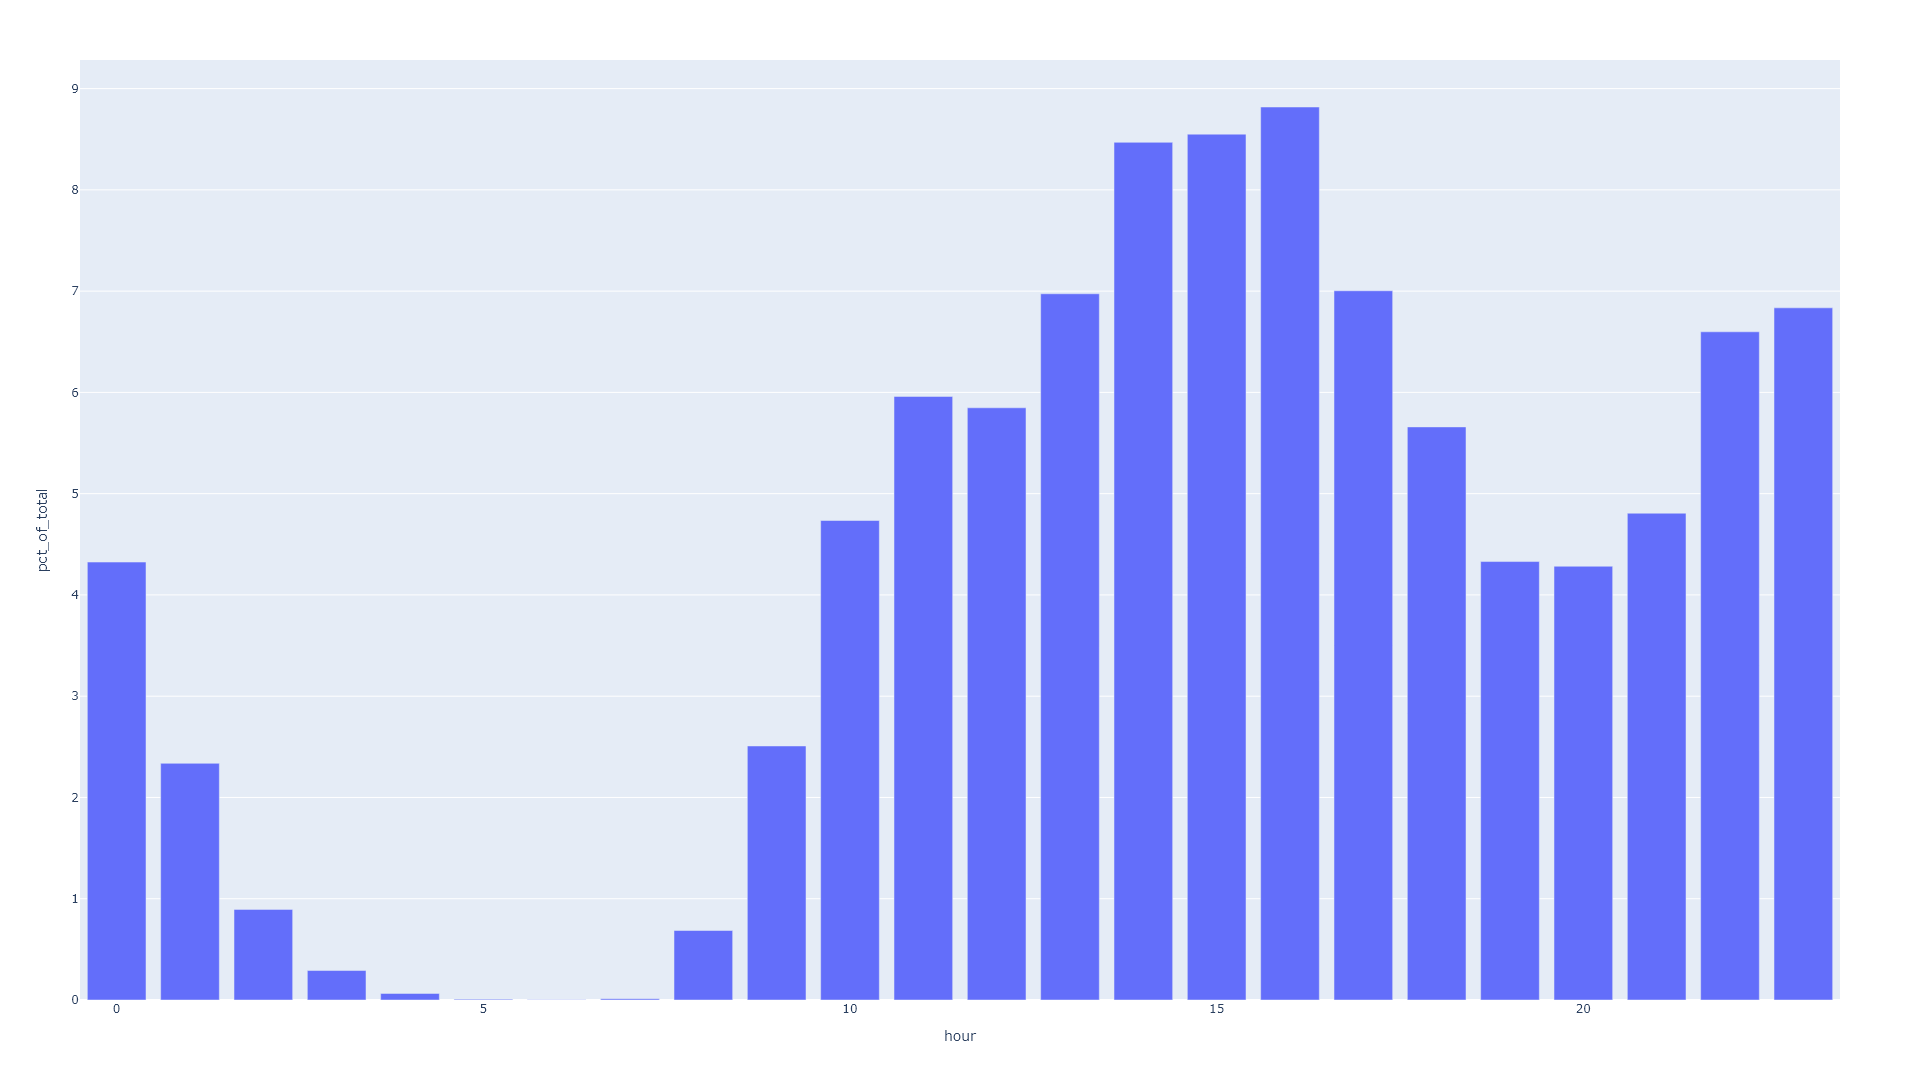

In [64]:
image_width = 1920
image_height = image_width * 9/16
px_keypresses_by_hour.write_image(r'graphs\px_keypresses_by_hour_static.png', width = image_width, height = image_height, engine = 'kaleido')
Image(r'graphs\px_keypresses_by_hour_static.png')

In [65]:
end_time = time.time()
run_time = end_time - start_time
run_minutes = run_time // 60
run_seconds = run_time % 60
# print("Completed run at",time.ctime(end_time),"(local time)")
# print("Total run time:",'{:.2f}'.format(run_time),"second(s) ("+str(run_minutes),"minute(s) and",'{:.2f}'.format(run_seconds),"second(s))") # Only meaningful when the program is run nonstop from start to finish


In [66]:
input() # Keeps console window open when running the file in a command prompt.
# It's not necessary for the Jupyter Notebook, but when I export this notebook
# as a Python script and then run the script on a scheduled basis, this 
# line gives me time to read the output.
# See nosklo's response at: https://stackoverflow.com/a/1000968/13097194

''